# Importing Required Modules

## General Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


## Modelling

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

## My modules

In [3]:
from my_modules.Predict import classification

# Functions

In [4]:
def text_classification(x, y, vect_model, pred_model, test_size=0.2, random_state=0, cv=10, pipeline_flag=False):

    # Train/Test Split
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state, stratify=y)

    if not pipeline_flag:

        # Vectorization
        vect_model.fit(x_train)
        x_vect_train = vect_model.transform(x_train)
        x_vect_test = vect_model.transform(x_test)

        # Prediction
        output = classification(x_vect_train, y_train, x_vect_test, y_test, pred_model, cv=cv)

    if pipeline_flag:

        # Create pipeline - Vectorization-Prediction
        pipeline = make_pipeline(vect_model, pred_model)

        # Run pipeline
        output = classification(x_train, y_train, x_test, y_test, pipeline, cv=cv)


    return output

    

# Loading the data

In [5]:
path = "Data/csv/fin_lab_large_processed.csv"
df = pd.read_csv(path)

# From Words to Numbers

In [6]:
y = df["sentiment"]
x = df["lemmas"]

lb = LabelBinarizer()
y = np.ravel(lb.fit_transform(y))


In [7]:
df

,text,lemmas,ngrams,named_ents,sentiment
0,Operating cash flow after investments totalled...,"['operate', 'cash', 'flow', 'investment', 'tot...","['operate_cash', 'operate_cash_flow', 'corresp...",[],negative
1,"TietoEnator was down 1.13 pct to 18.38 , exten...","['pct', 'extend', 'recent', 'low', 'week', 'se...","['recent_low', 'last_week']",[],negative
2,In Finland 's Hobby Hall 's sales decreased by...,"['sale', 'decrease', 'international', 'sale', ...",['international_sale'],['Finland/GPE'],negative
3,"Svyturys-Utenos Alus , which is controlled by ...","['control', 'nordic', 'group', 'post', 'cent',...",['nordic_group'],[],positive
4,'' Lining stone sales were also good in the ea...,"['lining', 'stone', 'sale', 'good', 'early', '...",['early_autumn'],[],positive
...,...,...,...,...,...
1940,The chain posted sales of 298 million euros fo...,"['chain', 'post', 'sale', 'euro', 'rise', 'per...",['post_sale'],[],positive
1941,Satama earned Data Management Solutions compet...,"['earn', 'competency', 'specialization', 'rece...",[],[],positive
1942,"Rinkuskiai raised the sales by 18.1 percent , ...","['raise', 'sale', 'percent', 'liter', 'sale', ...",[],"['Rinkuskiai/PERSON', 'Kauno_Alus/PERSON']",positive
1943,Earnings per share ( EPS ) in the first half o...,"['earning', 'share', 'half', 'amount', 'year',...",['first_half'],[],negative


In [8]:
print(y)

[0 0 0 ... 1 0 1]


## Train/test Split

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)

In [10]:
x_train

975     ['operate', 'profit', 'exclude', 'restructure'...
966                   ['operating', 'profit', 'increase']
1454    ['hack', 'extra', 'nefarious', 'tweet', 'activ...
1372               ['earning', 'share', 'amount', 'loss']
1174    ['say', 'expect', 'net', 'sale', 'compare', 'r...
                              ...                        
1563    ['accord', 'finnish', 'petrol', 'station', 'ch...
1922    ['mobile', 'phone', 'sale', 'rise', 'euro', 'e...
806     ['representative', 'sign', 'framework', 'agree...
1536                        ['net', 'interest', 'income']
853     ['addition', 'start', 'produce', 'new', 'membe...
Name: lemmas, Length: 1556, dtype: object

In [11]:
x_test

717     ['quarter', 'underlie', 'operating', 'profit',...
891     ['strike', 'estimate', 'incur', 'net', 'loss',...
1099    ['commission', 'income', 'increase', 'lending'...
1516         ['finnish', 'expand', 'business', 'quickly']
746     ['software', 'develop', 'accord', 'long', 'ter...
                              ...                        
1581    ['factory', 'locate', 'suburb', 'west', 'fully...
1866                                 ['great', 'product']
173     ['group', 'month', 'operating', 'profit', 'gro...
269     ['amending', 'proposal', 'simplify', 'propose'...
189     ['container', 'shipping', 'group', 'finnish', ...
Name: lemmas, Length: 389, dtype: object

In [12]:
pd.DataFrame(y_train)[0].value_counts()

1    1077
0     479
Name: 0, dtype: int64

In [13]:
pd.DataFrame(y_test)[0].value_counts()

1    269
0    120
Name: 0, dtype: int64

## Vectorization - Bag of Words

In [14]:
cv = CountVectorizer()

In [15]:
cv.fit(x_train)

x_bow_train = cv.transform(x_train)
x_bow_test = cv.transform(x_test)

print(f'x_bow_train: {x_bow_train.shape}')
print(f'x_bow_test: {x_bow_test.shape}')

x_bow_train: (1556, 2277)
x_bow_test: (389, 2277)


In [16]:
x_bow_train_df = pd.DataFrame(x_bow_test.toarray(), columns=cv.get_feature_names())

C:\Users\ehern\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Top 100 more frequent lemmas in the IMDb train corpus

In [17]:
list_tuples = []

for column in x_bow_train_df.columns:

    list_tuples.append((column, x_bow_train_df[column].sum()))

In [18]:
list_tuples.sort(key=lambda tup:tup[1], reverse=True)
print(list_tuples[0:100])

[('profit', 68), ('say', 67), ('year', 67), ('company', 66), ('sale', 64), ('net', 58), ('period', 52), ('mln', 47), ('increase', 42), ('loss', 40), ('finnish', 38), ('quarter', 37), ('corresponding', 27), ('compare', 25), ('operate', 23), ('rise', 23), ('service', 23), ('market', 22), ('total', 22), ('euro', 21), ('operating', 21), ('share', 20), ('expect', 19), ('today', 19), ('month', 18), ('business', 17), ('group', 17), ('operation', 17), ('eur', 16), ('result', 16), ('solution', 16), ('contract', 15), ('cost', 15), ('maker', 14), ('growth', 13), ('high', 13), ('price', 13), ('product', 13), ('technology', 13), ('continue', 12), ('decrease', 12), ('early', 12), ('percent', 12), ('accord', 11), ('agreement', 11), ('half', 11), ('improve', 11), ('paper', 11), ('sign', 11), ('base', 10), ('order', 10), ('plant', 10), ('project', 10), ('report', 10), ('second', 10), ('unit', 10), ('develop', 9), ('end', 9), ('estimate', 9), ('fall', 9), ('lay', 9), ('narrow', 9), ('new', 9), ('pretax'

## Vectorization - TF - IDF

In [19]:
tfidf = TfidfVectorizer()

In [20]:
tfidf.fit(x_train)

x_tfidf_train = tfidf.transform(x_train)
x_tfidf_test = tfidf.transform(x_test)

print(f'x_tfidf_train: {x_bow_train.shape}')
print(f'x_tfidf_test: {x_bow_test.shape}')

x_tfidf_train: (1556, 2277)
x_tfidf_test: (389, 2277)


# A flexible function for text classification

## Random Forest

In [21]:
rf=RandomForestClassifier(max_depth=20, n_estimators=100, random_state=0)

### Bag of Words - raw text

-----------------
The model score using K-fold cross validation (k=15) is 0.774 with a standard deviation of 0.023
-----------------
The performance metrics of the model


,train,test
error_metric,,
val_mean_score (k=15),0.774415,-
val_std (k=15),0.022832,-
accuracy,0.849614,0.771208
precision,0.821510,0.754237
recall,1.000000,0.992565


-----------------
Confusion matrix for the train set
-----------------


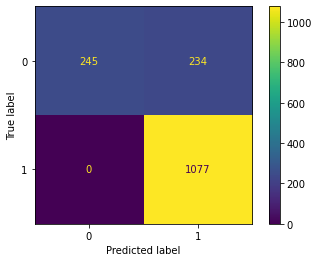

Confusion matrix for the test set
-----------------


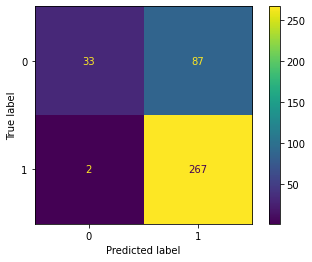

In [22]:
output_rf_bow_raw = text_classification(df["text"], y, CountVectorizer(), rf, cv=15, test_size=0.2, random_state=0, pipeline_flag=True)

### Bag of Words - Lemmas

-----------------
The model score using K-fold cross validation (k=15) is 0.794 with a standard deviation of 0.024
-----------------
The performance metrics of the model


,train,test
error_metric,,
val_mean_score (k=15),0.793758,-
val_std (k=15),0.023849,-
accuracy,0.828406,0.766067
precision,0.801339,0.75
recall,1.000000,0.992565


-----------------
Confusion matrix for the train set
-----------------


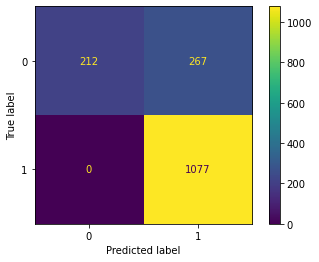

Confusion matrix for the test set
-----------------


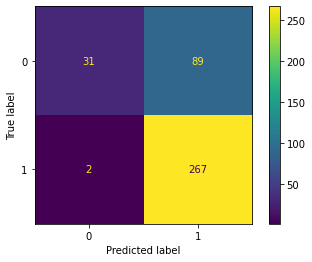

In [23]:
output_rf_bow_lemmas = text_classification(df["lemmas"], y, CountVectorizer(), rf, cv=15, test_size=0.2, random_state=20, pipeline_flag=True)

### Bag of Words - ngrams

-----------------
The model score using K-fold cross validation (k=10) is 0.703 with a standard deviation of 0.007
-----------------
The performance metrics of the model


,train,test
error_metric,,
val_mean_score (k=10),0.703077,-
val_std (k=10),0.006584,-
accuracy,0.715296,0.701799
precision,0.708553,0.699739
recall,1.000000,0.996283


-----------------
Confusion matrix for the train set
-----------------


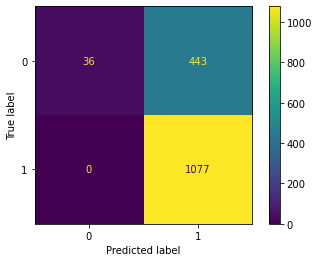

Confusion matrix for the test set
-----------------


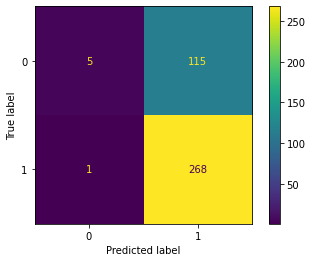

In [26]:
output_rf_bow_ngrams = text_classification(df["ngrams"], y, CountVectorizer(), rf, cv=10, test_size=0.2, random_state=0, pipeline_flag=True)

### TF_IDF - Lemmas

-----------------
The model score using K-fold cross validation (k=10) is 0.781 with a standard deviation of 0.022
-----------------
The performance metrics of the model


,train,test
error_metric,,
val_mean_score (k=10),0.781485,-
val_std (k=10),0.022162,-
accuracy,0.847044,0.766067
precision,0.819011,0.751412
recall,1.000000,0.988848


-----------------
Confusion matrix for the train set
-----------------


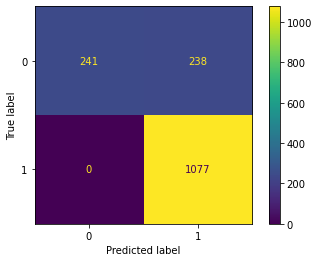

Confusion matrix for the test set
-----------------


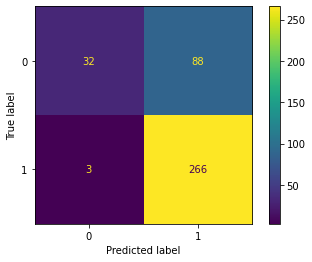

In [27]:
output_rf_tfidf_lemmas = text_classification(df["lemmas"], y, TfidfVectorizer(), rf, cv=10, test_size=0.2, random_state=0, pipeline_flag=True)

## SVM

In [28]:
svm = LinearSVC(random_state=0, tol=1e-2, max_iter=5000)

### Bag of Words - Lemmas

-----------------
The model score using K-fold cross validation (k=10) is 0.845 with a standard deviation of 0.02
-----------------
The performance metrics of the model


,train,test
error_metric,,
val_mean_score (k=10),0.845116,-
val_std (k=10),0.020394,-
accuracy,0.982648,0.845758
precision,0.988827,0.849498
recall,0.986072,0.944238


-----------------
Confusion matrix for the train set
-----------------


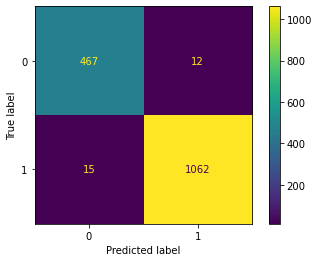

Confusion matrix for the test set
-----------------


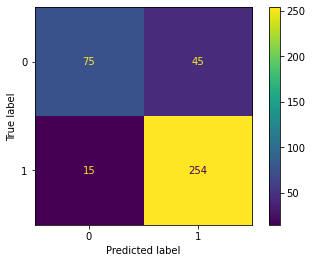

In [29]:
output_svm_bow_lemmas = text_classification(df["lemmas"], y, CountVectorizer(), svm, cv=10, test_size=0.2, random_state=0, pipeline_flag=True)

### Bag of Words - ngrams

-----------------
The model score using K-fold cross validation (k=10) is 0.701 with a standard deviation of 0.025
-----------------
The performance metrics of the model


,train,test
error_metric,,
val_mean_score (k=10),0.700500,-
val_std (k=10),0.025439,-
accuracy,0.852185,0.717224
precision,0.832157,0.726496
recall,0.985144,0.947955


-----------------
Confusion matrix for the train set
-----------------


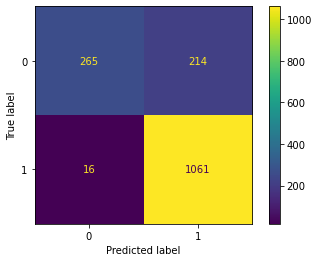

Confusion matrix for the test set
-----------------


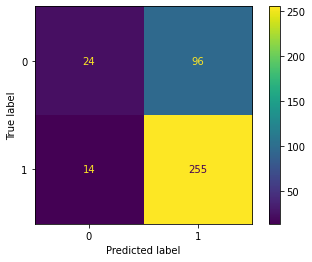

In [30]:
output_svm_bow_ngrams = text_classification(df["ngrams"], y, CountVectorizer(), svm, cv=10, test_size=0.2, random_state=0, pipeline_flag=True)

### TF_ITF - lemmas

-----------------
The model score using K-fold cross validation (k=10) is 0.848 with a standard deviation of 0.027
-----------------
The performance metrics of the model


,train,test
error_metric,,
val_mean_score (k=10),0.848329,-
val_std (k=10),0.027320,-
accuracy,0.976864,0.843188
precision,0.984186,0.844371
recall,0.982358,0.947955


-----------------
Confusion matrix for the train set
-----------------


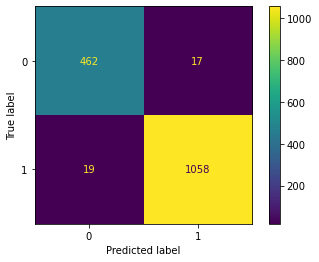

Confusion matrix for the test set
-----------------


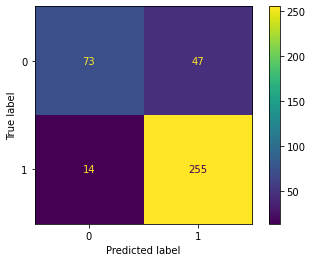

In [31]:
output_svm_tfif_lemmas = text_classification(df["lemmas"], y, TfidfVectorizer(), svm, cv=10, test_size=0.2, random_state=0, pipeline_flag=True)

## Naive Bayes

In [32]:
nb = MultinomialNB()

### Bag of Words - Lemmas

-----------------
The model score using K-fold cross validation (k=10) is 0.829 with a standard deviation of 0.02
-----------------
The performance metrics of the model


,train,test
error_metric,,
val_mean_score (k=10),0.829012,-
val_std (k=10),0.020262,-
accuracy,0.921594,0.85347
precision,0.968597,0.873239
recall,0.916435,0.921933


-----------------
Confusion matrix for the train set
-----------------


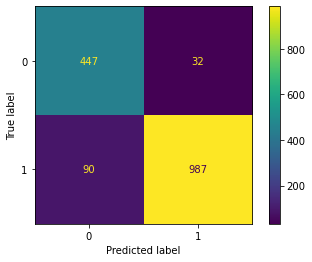

Confusion matrix for the test set
-----------------


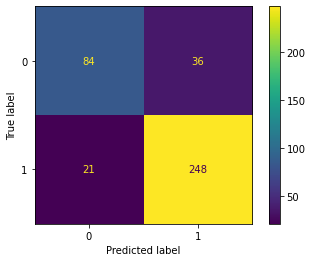

In [33]:
output_nb_bow_lemmas = text_classification(df["lemmas"], y, CountVectorizer(), nb, cv=10, test_size=0.2, random_state=0, pipeline_flag=True)

### TF_ITF - lemmas

-----------------
The model score using K-fold cross validation (k=10) is 0.786 with a standard deviation of 0.019
-----------------
The performance metrics of the model


,train,test
error_metric,,
val_mean_score (k=10),0.786009,-
val_std (k=10),0.018858,-
accuracy,0.877892,0.817481
precision,0.853386,0.796407
recall,0.994429,0.988848


-----------------
Confusion matrix for the train set
-----------------


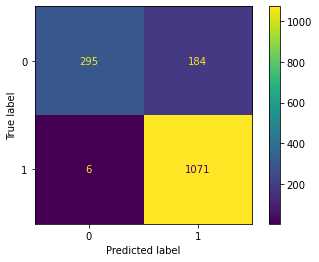

Confusion matrix for the test set
-----------------


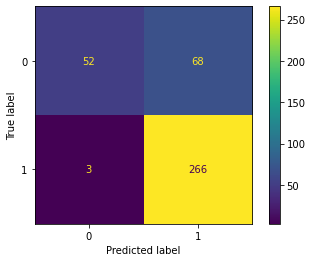

In [34]:
output_nb_tfif_lemmas = text_classification(df["lemmas"], y, TfidfVectorizer(), nb, cv=10, test_size=0.2, random_state=0, pipeline_flag=True)

# Final Model - Naive Bayes with TF_IDF and lemmas

-----------------
The model score using K-fold cross validation (k=15) is 0.805 with a standard deviation of 0.028
-----------------
The performance metrics of the model


,train,test
error_metric,,
val_mean_score (k=15),0.805309,-
val_std (k=15),0.028165,-
accuracy,0.879820,0.794344
precision,0.855431,0.777126
recall,0.994429,0.98513


-----------------
Confusion matrix for the train set
-----------------


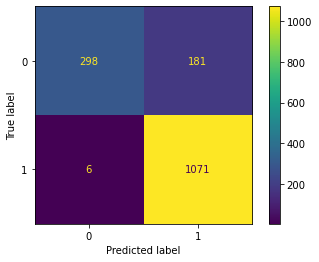

Confusion matrix for the test set
-----------------


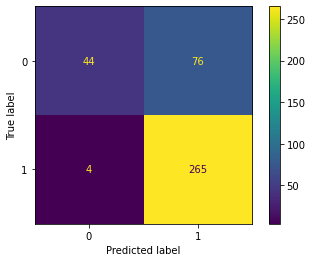

In [41]:
nb = MultinomialNB()
output_nb_tfif_lemmas = text_classification(df["lemmas"], y, TfidfVectorizer(), nb, cv=15, test_size=0.2, random_state=20, pipeline_flag=True)